In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

import random

## Helper fxns

In [16]:
def white_balance_transform(im_rgb):
    """
    Requires HWC uint8 input
    Originally in SimplestColorBalance.m
    """
    # This section basically reshapes into vectors per channel I think?
   
    # if RGB
    if len(im_rgb.shape) == 3:
        R = np.sum(im_rgb[:, :, 0], axis=None)
        G = np.sum(im_rgb[:, :, 1], axis=None)
        B = np.sum(im_rgb[:, :, 2], axis=None)
        
        maxpix = max(R, G, B)
        ratio = np.array([maxpix / R, maxpix / G, maxpix / B])

        satLevel1 = 0.005 * ratio
        satLevel2 = 0.005 * ratio

        m, n, p = im_rgb.shape
        im_rgb_flat = np.zeros(shape=(p, m * n))
        for i in range(0, p):
            im_rgb_flat[i, :] = np.reshape(im_rgb[:, :, i], (1, m * n))

    # if grayscale
    else:
        satLevel1 = np.array([0.001])
        satLevel2 = np.array([0.005])
        m, n = im_rgb.shape
        p = 1
        im_rgb_flat = np.reshape(im_rgb, (1, m * n))
        
    wb = np.zeros(shape=im_rgb_flat.shape)
    for ch in range(p):
        q = [satLevel1[ch], 1 - satLevel2[ch]]
        tiles = np.quantile(im_rgb_flat[ch, :], q)
        temp = im_rgb_flat[ch, :]
        temp[temp < tiles[0]] = tiles[0]
        temp[temp > tiles[1]] = tiles[1]
        wb[ch, :] = temp
        bottom = min(wb[ch, :])
        top = max(wb[ch, :])
        wb[ch, :] = (wb[ch, :] - bottom) * 255 / (top - bottom)
        
    if len(im_rgb.shape) == 3:
        outval = np.zeros(shape=im_rgb.shape);
        for i in range(p):
            outval[:, :, i] = np.reshape(wb[i, :], (m, n)); 

    else:
        outval = np.reshape(wb, (m, n))
    
    return outval.astype(np.uint8)

In [23]:
def gamma_correction(im):
    gc = np.power(im / 255, 0.7)
    gc = np.clip(255 * gc, 0, 255)
    gc = gc.astype(np.uint8)
    return gc

In [4]:
def histeq(im_rgb):
    im_lab = cv2.cvtColor(im_rgb, cv2.COLOR_RGB2LAB)
    
    clahe = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
    el = clahe.apply(im_lab[:, :, 0])
        
    im_he = im_lab.copy()
    im_he[:, :, 0] = el
    im_he_rgb = cv2.cvtColor(im_he, cv2.COLOR_LAB2RGB)

    return im_he_rgb

## Load sample images

In [28]:
raw_im_dir = Path("../data/bundled/input_train/")

In [6]:
raw_ims_paths = list(raw_im_dir.glob("*"))

In [7]:
sampled_ims_paths = random.sample(raw_ims_paths, k=10)

In [8]:
bgrs = [cv2.imread(i.as_posix()) for i in sampled_ims_paths]
rgbs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in bgrs]

In [29]:
true_he_dir = Path("../data/bundled/input_ce_train/")
true_gc_dir = Path("../data/bundled/input_gc_train/")
true_wb_dir = Path("../data/bundled/input_wb_train/")

In [34]:
true_hes = [cv2.imread((true_he_dir / i.name).as_posix()) for i in sampled_ims_paths]
true_gcs = [cv2.imread((true_gc_dir / i.name).as_posix()) for i in sampled_ims_paths]
true_wbs = [cv2.imread((true_wb_dir / i.name).as_posix()) for i in sampled_ims_paths]

In [36]:
true_hes = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in true_hes]
true_gcs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in true_gcs]
true_wbs = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in true_wbs]

## Example

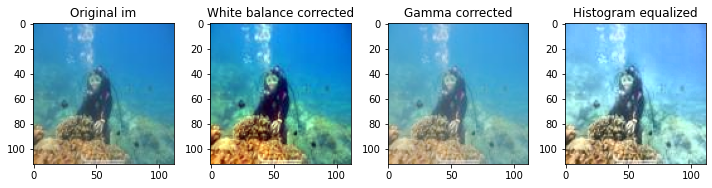

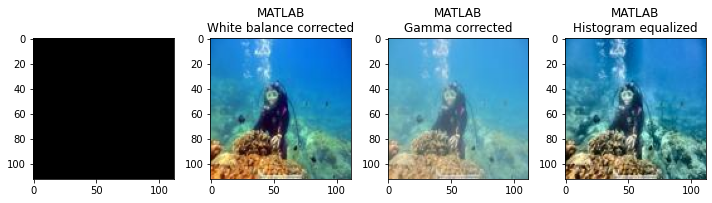

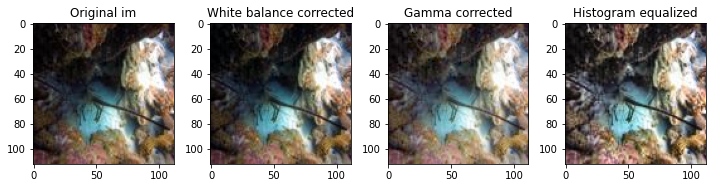

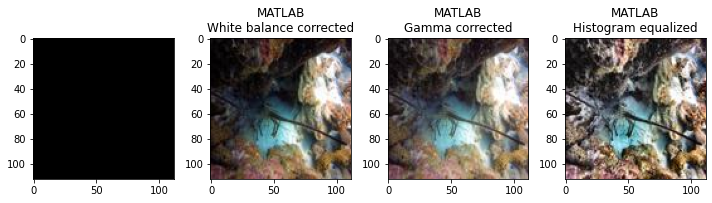

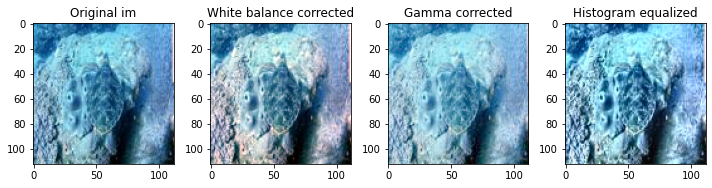

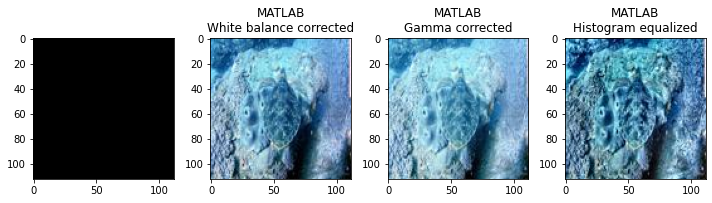

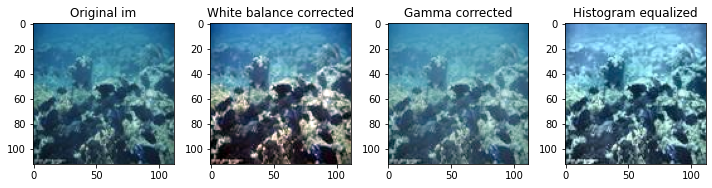

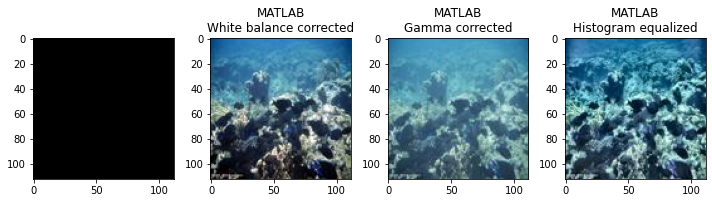

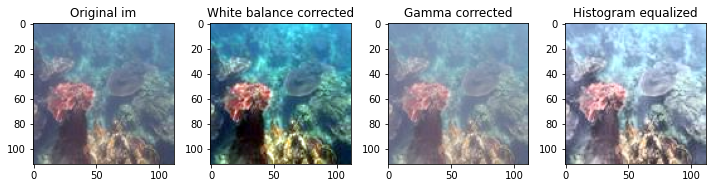

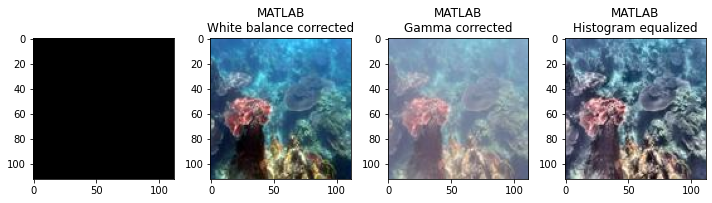

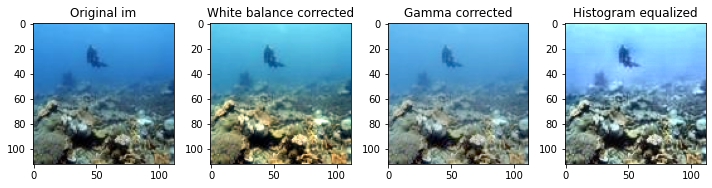

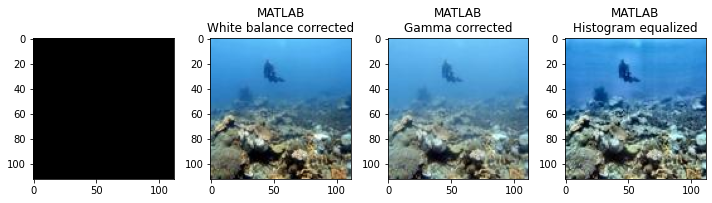

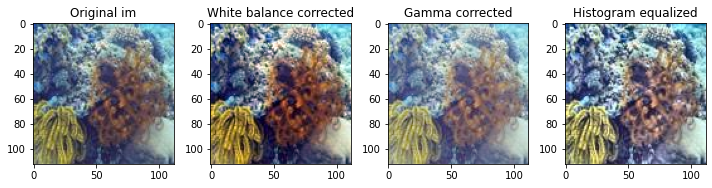

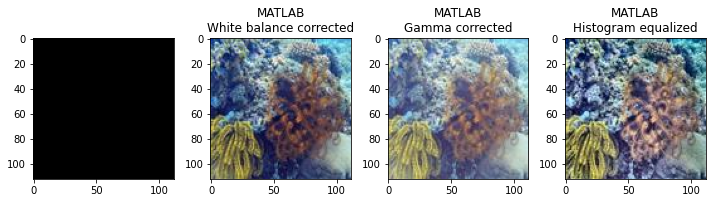

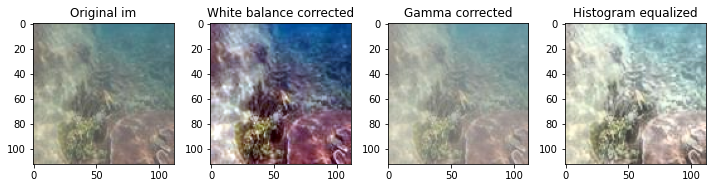

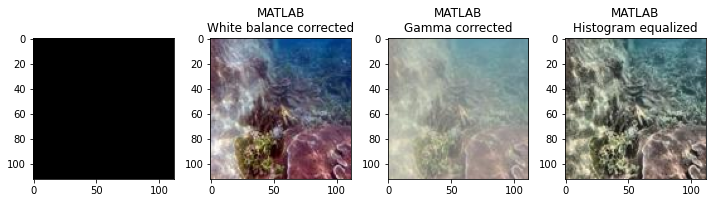

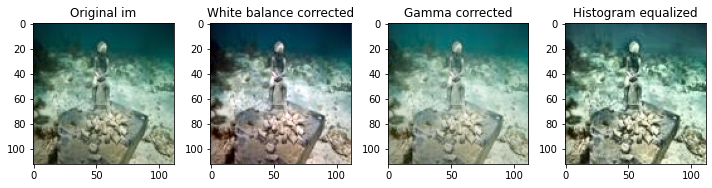

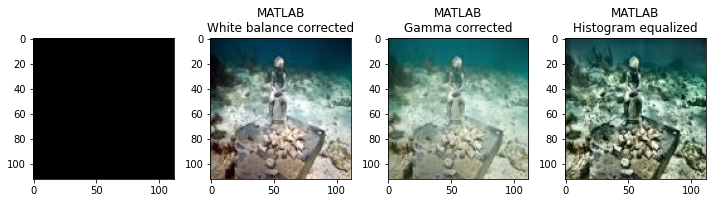

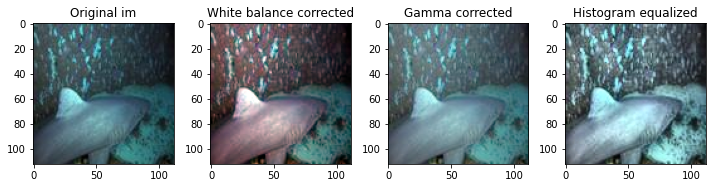

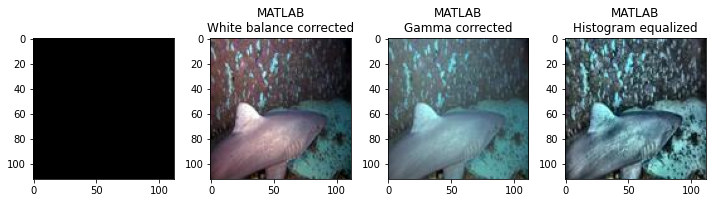

In [40]:
for count, sample_rgb in enumerate(rgbs):
    wb = white_balance_transform(sample_rgb)
    gc = gamma_correction(sample_rgb)
    he = histeq(sample_rgb)
    
    fig, ax = plt.subplots(ncols=4, figsize=(10, 3))

    ax[0].imshow(sample_rgb)
    ax[1].imshow(wb)
    ax[2].imshow(gc)
    ax[3].imshow(he)

    ax[0].set_title("Original im")
    ax[1].set_title("White balance corrected")
    ax[2].set_title("Gamma corrected")
    ax[3].set_title("Histogram equalized")

    fig.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(ncols=4, figsize=(10, 3))

    ax[0].imshow(np.zeros_like(sample_rgb) * 255) # plot sth else it goes out of shape
    ax[1].imshow(true_wbs[count])
    ax[2].imshow(true_gcs[count])
    ax[3].imshow(true_hes[count])

    ax[1].set_title("MATLAB\nWhite balance corrected")
    ax[2].set_title("MATLAB\nGamma corrected")
    ax[3].set_title("MATLAB\nHistogram equalized")

    fig.tight_layout()
    plt.show()

White balance and gamma correction are exactly the same, just histogram equalization is a different implementation.

Implemented fxns in `data.py`.